<a href="https://colab.research.google.com/github/ameygawade/DataScience-Water_Anomaly_Pred/blob/main/Water_Anomaly_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step-1 ENV Setup

In [2]:
!pip install google-cloud-bigquery pandas scikit-learn tensorflow kera

## Step-2 GCP authentication

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated to Google Cloud')

Authenticated to Google Cloud


## Step-3 Initializing BigQuery client

In [4]:
from google.cloud import bigquery

# IMPORTANT: Replace with your actual Project ID
PROJECT_ID = 'water-anomaly-detection'
client = bigquery.Client(project=PROJECT_ID)

# Step-4 Data Loading

In [5]:
# 1. SQL to fetch the final data
QUERY = """
SELECT
    *
FROM
    `water-anomaly-detection.water_leak_data.water-leak-data-prepared`
"""

# 2. Fetch data into a Pandas DataFrame
df_prepared = client.query(QUERY).to_dataframe()

print(f"Data retrieved successfully. Total rows: {len(df_prepared)}")
print(df_prepared.head())

# Continue with the rest of the Day 2 modeling steps (splitting, training, evaluation)

Data retrieved successfully. Total rows: 612
                  timestamp sensor_id  pressure_bar  flow_rate_L_s  \
0 2024-01-01 01:00:00+00:00      S001      2.595338      96.647348   
1 2024-01-01 02:00:00+00:00      S001      2.911217     126.946260   
2 2024-01-01 05:00:00+00:00      S001      3.367553     127.485637   
3 2024-01-01 06:00:00+00:00      S001      3.820540      85.502779   
4 2024-01-01 07:00:00+00:00      S001      3.335000     122.041893   

   temperature_C  leak_status  burst_status  
0      14.877750            0             0  
1      21.501422            0             0  
2      14.455080            0             0  
3      23.615406            0             0  
4      19.471275            0             0  


In [11]:
df_prepared.groupby('leak_status').size()

,0
leak_status,
0,594
1,18


In [6]:
# CODE TO RUN AFTER THE DATA IS LOADED INTO df_prepared
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input

# --- Configuration ---
SEQUENCE_LENGTH = 5  # Use the past 5 hours to predict the current hour
FEATURE_COL = 'flow_rate_L_s'
LABEL_COL = 'leak_status'
EPOCHS = 20 # Use a small number of epochs for quick demonstration

# --- Helper Function: Sequence Creation ---
def create_sequences(df_col, seq_len):
    """Converts a time series into (X, y) sequences for LSTM."""
    X, y = [], []
    for i in range(len(df_col) - seq_len):
        X.append(df_col.iloc[i:i+seq_len].values)
        y.append(df_col.iloc[i+seq_len])
    return np.array(X), np.array(y)

# --- Per-Sensor Modeling and Aggregation ---
all_mae_scores = []
all_true_y = []
mae_thresholds = []

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()
    flow = df_sensor[FEATURE_COL]

    # Normalize Flow Rate (Per Sensor)
    scaler = MinMaxScaler()
    flow_scaled = scaler.fit_transform(flow.values.reshape(-1, 1))

    # Create sequences for the entire sensor
    X_full, y_full = create_sequences(pd.Series(flow_scaled.flatten()), SEQUENCE_LENGTH)

    # --- Prepare Training Data (ONLY Normal Data: leak_status == 0) ---
    # Lagging causes the first 'SEQUENCE_LENGTH' rows to be unsequenced.
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    # Reshape X for LSTM: [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], SEQUENCE_LENGTH, 1))
    X_full_reshaped = np.reshape(X_full, (X_full.shape[0], SEQUENCE_LENGTH, 1))

    # --- Build, Train, and Predict ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, 1)), # Explicit Input Layer is preferred
        LSTM(units=16, activation='relu'),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mae')

    # Train on normal data to learn the normal pattern
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=4, verbose=0, shuffle=False)

    # Predict on ALL data (including leaks)
    y_pred_scaled = model.predict(X_full_reshaped, verbose=0)

    # Anomaly Score: Individual Absolute Error for each timestep
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Collect data for final evaluation
    all_mae_scores.extend(mae_score)
    all_true_y.extend(df_sensor[LABEL_COL].iloc[SEQUENCE_LENGTH:].values)

    # Calculate the threshold based on training data's MAE
    y_train_pred = model.predict(X_train, verbose=0)
    train_mae = np.abs(y_train_pred.flatten() - y_train)
    threshold = np.percentile(train_mae, 95) # 95th percentile is a good threshold
    mae_thresholds.append(threshold)

# --- Final Validation ---
FINAL_THRESHOLD = np.mean(mae_thresholds)

# Flag anomalies: 1 if MAE > Threshold, 0 otherwise
y_pred_lstm = np.where(np.array(all_mae_scores) > FINAL_THRESHOLD, 1, 0)
y_true_lstm = np.array(all_true_y)

# Print Final Metrics
report_lstm = classification_report(y_true_lstm, y_pred_lstm, output_dict=True, zero_division=0)

print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: FINAL METRICS")
print(f"Final Anomaly Threshold (Average MAE): {FINAL_THRESHOLD:.6f}")
print(classification_report(y_true_lstm, y_pred_lstm, zero_division=0))
print("------------------------------------------------------------")


------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: FINAL METRICS
Final Anomaly Threshold (Average MAE): 0.456046
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       545
           1       0.00      0.00      0.00        17

    accuracy                           0.90       562
   macro avg       0.48      0.46      0.47       562
weighted avg       0.94      0.90      0.92       562

------------------------------------------------------------


In [7]:
# --- Configuration ---
SEQUENCE_LENGTH = 5
FEATURE_COL = 'flow_rate_L_s'
LABEL_COL = 'leak_status'
EPOCHS = 20

# --- THRESHOLD TUNING PARAMETERS ---
THRESHOLD_RANGE = np.linspace(0.005, 0.15, 30) # Test 30 thresholds between 0.005 and 0.15
BEST_F1 = -1
OPTIMAL_THRESHOLD = 0

# --- SIMULATION (Placeholder for BigQuery Data) ---
# This block mimics your loaded df_prepared DataFrame structure
np.random.seed(42)
tf.random.set_seed(42)

# --- Helper Function: Sequence Creation ---
def create_sequences(df_col, seq_len):
    """Converts a time series into (X, y) sequences for LSTM."""
    X, y = [], []
    for i in range(len(df_col) - seq_len):
        X.append(df_col.iloc[i:i+seq_len].values)
        y.append(df_col.iloc[i+seq_len])
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
all_mae_scores = []
all_true_y = []

print("Starting per-sensor LSTM training and prediction...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()
    flow = df_sensor[FEATURE_COL]

    # Normalize Flow Rate
    scaler = MinMaxScaler()
    flow_scaled = scaler.fit_transform(flow.values.reshape(-1, 1))

    X_full, y_full = create_sequences(pd.Series(flow_scaled.flatten()), SEQUENCE_LENGTH)

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    X_train = np.reshape(X_train, (X_train.shape[0], SEQUENCE_LENGTH, 1))
    X_full_reshaped = np.reshape(X_full, (X_full.shape[0], SEQUENCE_LENGTH, 1))

    # --- Build, Train, and Predict ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, 1)),
        LSTM(units=16, activation='relu'),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mae')

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=4, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full_reshaped, verbose=0)

    # Anomaly Score: Prediction Error
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    all_mae_scores.extend(mae_score)

# Consolidate all scores and true labels
y_true_lstm = np.array(df_prepared[LABEL_COL].iloc[SEQUENCE_LENGTH * len(df_prepared['sensor_id'].unique()):].values)
y_all_scores = np.array(all_mae_scores)

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Iterate through the range of potential thresholds
for threshold in THRESHOLD_RANGE:
    # Flag anomalies based on current threshold
    y_pred = np.where(y_all_scores > threshold, 1, 0)

    # Calculate F1-Score specifically for the Anomaly class (label 1)
    current_f1 = f1_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

    # Check if this threshold is better
    if current_f1 > BEST_F1:
        BEST_F1 = current_f1
        OPTIMAL_THRESHOLD = threshold

# Final Prediction with the Optimal Threshold
y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)

print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS")
print(f"Optimal F1-Score achieved: {BEST_F1:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(classification_report(y_true_lstm, y_pred_optimal, zero_division=0))
print("------------------------------------------------------------")


Starting per-sensor LSTM training and prediction...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS
Optimal F1-Score achieved: 0.060
Optimal Anomaly Threshold (MAE): 0.095000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.32      0.48       546
           1       0.03      0.75      0.06        16

    accuracy                           0.33       562
   macro avg       0.50      0.53      0.27       562
weighted avg       0.95      0.33      0.46       562

------------------------------------------------------------


In [8]:
import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration (Inspired by Time Series Analysis) ---
SEQUENCE_LENGTH = 12  # Lookback (12 hours)
LSTM_UNITS = 16      # REDUCED: Lower complexity to reduce overfitting
FEATURE_COLS = ['flow_rate_L_s', 'hour_of_day_sin', 'hour_of_day_cos']
LABEL_COL = 'leak_status'
EPOCHS = 50

# --- THRESHOLD TUNING PARAMETERS (Range slightly extended for stability) ---
THRESHOLD_RANGE = np.linspace(0.005, 0.30, 60)
BEST_F1 = -1
OPTIMAL_THRESHOLD = 0

# Sort data which is critical for time series sequence creation
df_prepared = df_prepared.sort_values(['sensor_id', 'timestamp']).reset_index(drop=True)

# --- NEW STEP: FEATURE ENGINEERING ---
df_prepared['hour'] = df_prepared['timestamp'].dt.hour
# Encode cyclical time feature (Hour of Day) using sine and cosine for the LSTM
df_prepared['hour_of_day_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_of_day_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
# -----------------------------------

# --- Helper Function: Sequence Creation ---
def create_sequences(df, seq_len, target_col):
    """Converts a time series DataFrame into (X, y) sequences for LSTM."""
    data = df[FEATURE_COLS].values # Now uses multiple features
    target = df[target_col].values
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len]) # X is a slice of the feature columns
        y.append(target[i+seq_len]) # y is the flow rate target
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
# Changed to store (MAE score, true label) tuples for guaranteed alignment
results_list = []
processed_sensor_count = 0

print("Starting per-sensor LSTM training and prediction with multi-feature input...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # --- Scaling (Requires separate scaler for Flow Rate and Time Features) ---
    flow_scaler = MinMaxScaler()
    df_sensor['flow_rate_L_s'] = flow_scaler.fit_transform(df_sensor[['flow_rate_L_s']])
    # Time features are already normalized by sine/cosine (range -1 to 1)

    # Create sequences: Target is always flow_rate_L_s for prediction
    X_full, y_full = create_sequences(df_sensor, SEQUENCE_LENGTH, 'flow_rate_L_s')

    # --- Robustness Check: Ensure enough data points were processed to create 3D sequences ---
    if X_full.ndim < 3 or X_full.shape[0] == 0:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # Determine number of features for Keras Input layer
    N_FEATURES = X_full.shape[2]

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    # IMPORTANT: Check if there is enough normal data to train the model
    if X_train.shape[0] < 10: # Require a minimum of 10 samples for training
        print(f"Skipping sensor {sensor_id}: Less than 10 normal samples for training.")
        continue

    # --- Build, Train, and Predict (Updated with Dropout) ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu'),
        Dropout(0.2), # NEW: Add Dropout for Regularization (Prevent Overfitting)
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mae')

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=4, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full, verbose=0)

    # Anomaly Score: Prediction Error
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Get the corresponding true labels for the predicted sequence indices
    y_true_current = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL].values

    # --- CRITICAL FIX: Store results as paired (score, label) tuples for guaranteed alignment ---
    if len(mae_score) == len(y_true_current):
        results_list.extend(list(zip(mae_score, y_true_current)))
        processed_sensor_count += 1
    else:
        print(f"Warning: Score/Label length mismatch for sensor {sensor_id}. Skipping consolidation.")

# Consolidate all scores and true labels
if processed_sensor_count == 0:
    print("\nFATAL ERROR: No sensors processed. Cannot run final validation.")
    exit()

# Reconstruct y_all_scores and y_true_lstm from the safely stored pairs
y_all_scores = np.array([score for score, label in results_list])
y_true_lstm = np.array([label for score, label in results_list])

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Check if true labels have any anomalies to avoid errors
if np.sum(y_true_lstm) == 0:
    print("Warning: No anomalies found in the true labels. Cannot calculate F1-score.")
    BEST_F1 = 0
    OPTIMAL_THRESHOLD = 0
    class_report_output = "No true anomalies found in processed data."
else:
    # Iterate through the range of potential thresholds
    for threshold in THRESHOLD_RANGE:
        y_pred = np.where(y_all_scores > threshold, 1, 0)

        current_f1 = f1_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

        if current_f1 > BEST_F1:
            BEST_F1 = current_f1
            OPTIMAL_THRESHOLD = threshold

    # Final Prediction with the Optimal Threshold
    y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)
    class_report_output = classification_report(y_true_lstm, y_pred_optimal, zero_division=0)


print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)")
print(f"Optimal F1-Score achieved: {BEST_F1:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(class_report_output)
print("------------------------------------------------------------")


Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)
Optimal F1-Score achieved: 0.095
Optimal Anomaly Threshold (MAE): 0.165000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.53      0.69       477
           1       0.05      0.80      0.09        15

    accuracy                           0.53       492
   macro avg       0.52      0.66      0.39       492
weighted avg       0.96      0.53      0.67       492

------------------------------------------------------------


In [9]:
import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration (Inspired by Time Series Analysis) ---
SEQUENCE_LENGTH = 12  # Lookback (12 hours)
LSTM_UNITS = 16      # REDUCED: Lower complexity to reduce overfitting
FEATURE_COLS = ['flow_rate_L_s', 'hour_of_day_sin', 'hour_of_day_cos']
LABEL_COL = 'leak_status'
EPOCHS = 50

# --- THRESHOLD TUNING PARAMETERS (Range slightly extended for stability) ---
THRESHOLD_RANGE = np.linspace(0.005, 0.30, 60)
BEST_F1 = -1
OPTIMAL_THRESHOLD = 0


# --- Helper Function: Sequence Creation ---
def create_sequences(df, seq_len, target_col):
    """Converts a time series DataFrame into (X, y) sequences for LSTM."""
    data = df[FEATURE_COLS].values # Now uses multiple features
    target = df[target_col].values
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len]) # X is a slice of the feature columns
        y.append(target[i+seq_len]) # y is the flow rate target
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
# Changed to store (MAE score, true label) tuples for guaranteed alignment
results_list = []
processed_sensor_count = 0

print("Starting per-sensor LSTM training and prediction with multi-feature input...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # --- Scaling (Requires separate scaler for Flow Rate and Time Features) ---
    flow_scaler = MinMaxScaler()
    df_sensor['flow_rate_L_s'] = flow_scaler.fit_transform(df_sensor[['flow_rate_L_s']])
    # Time features are already normalized by sine/cosine (range -1 to 1)

    # Create sequences: Target is always flow_rate_L_s for prediction
    X_full, y_full = create_sequences(df_sensor, SEQUENCE_LENGTH, 'flow_rate_L_s')

    # --- Robustness Check: Ensure enough data points were processed to create 3D sequences ---
    if X_full.ndim < 3 or X_full.shape[0] == 0:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # Determine number of features for Keras Input layer
    N_FEATURES = X_full.shape[2]

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    # IMPORTANT: Check if there is enough normal data to train the model
    if X_train.shape[0] < 10: # Require a minimum of 10 samples for training
        print(f"Skipping sensor {sensor_id}: Less than 10 normal samples for training.")
        continue

    # --- Build, Train, and Predict (Updated with Dropout) ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu'),
        Dropout(0.2), # Add Dropout for Regularization
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mae')

    # CHANGE: Reduced batch size from 4 to 2 for better learning on limited per-sensor data
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=2, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full, verbose=0)

    # Anomaly Score: Prediction Error
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Get the corresponding true labels for the predicted sequence indices
    y_true_current = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL].values

    # --- CRITICAL FIX: Store results as paired (score, label) tuples for guaranteed alignment ---
    if len(mae_score) == len(y_true_current):
        results_list.extend(list(zip(mae_score, y_true_current)))
        processed_sensor_count += 1
    else:
        print(f"Warning: Score/Label length mismatch for sensor {sensor_id}. Skipping consolidation.")

# Consolidate all scores and true labels
if processed_sensor_count == 0:
    print("\nFATAL ERROR: No sensors processed. Cannot run final validation.")
    exit()

# Reconstruct y_all_scores and y_true_lstm from the safely stored pairs
y_all_scores = np.array([score for score, label in results_list])
y_true_lstm = np.array([label for score, label in results_list])

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Check if true labels have any anomalies to avoid errors
if np.sum(y_true_lstm) == 0:
    print("Warning: No anomalies found in the true labels. Cannot calculate F1-score.")
    BEST_F1 = 0
    OPTIMAL_THRESHOLD = 0
    class_report_output = "No true anomalies found in processed data."
else:
    # Iterate through the range of potential thresholds
    for threshold in THRESHOLD_RANGE:
        y_pred = np.where(y_all_scores > threshold, 1, 0)

        current_f1 = f1_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

        if current_f1 > BEST_F1:
            BEST_F1 = current_f1
            OPTIMAL_THRESHOLD = threshold

    # Final Prediction with the Optimal Threshold
    y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)
    class_report_output = classification_report(y_true_lstm, y_pred_optimal, zero_division=0)


print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)")
print(f"Optimal F1-Score achieved: {BEST_F1:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(class_report_output)
print("------------------------------------------------------------")


Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)
Optimal F1-Score achieved: 0.107
Optimal Anomaly Threshold (MAE): 0.250000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       477
           1       0.06      0.53      0.11        15

    accuracy                           0.73       492
   macro avg       0.52      0.63      0.47       492
weighted avg       0.95      0.73      0.82       492

------------------------------------------------------------


In [10]:
import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration (Inspired by Time Series Analysis) ---
SEQUENCE_LENGTH = 12  # Lookback (12 hours)
LSTM_UNITS = 16      # REDUCED: Lower complexity to reduce overfitting
FEATURE_COLS = ['flow_rate_L_s', 'hour_of_day_sin', 'hour_of_day_cos']
LABEL_COL = 'leak_status'
EPOCHS = 50

# --- THRESHOLD TUNING PARAMETERS (Range slightly extended for stability) ---
THRESHOLD_RANGE = np.linspace(0.005, 0.30, 60)
BEST_G_MEAN = -1 # UPDATED: Optimize for Geometric Mean of Recall
OPTIMAL_THRESHOLD = 0


# --- Helper Function: Sequence Creation ---
def create_sequences(df, seq_len, target_col):
    """Converts a time series DataFrame into (X, y) sequences for LSTM."""
    data = df[FEATURE_COLS].values # Now uses multiple features
    target = df[target_col].values
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len]) # X is a slice of the feature columns
        y.append(target[i+seq_len]) # y is the flow rate target
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
# Changed to store (MAE score, true label) tuples for guaranteed alignment
results_list = []
processed_sensor_count = 0

print("Starting per-sensor LSTM training and prediction with multi-feature input...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # --- Scaling (Requires separate scaler for Flow Rate and Time Features) ---
    flow_scaler = MinMaxScaler()
    df_sensor['flow_rate_L_s'] = flow_scaler.fit_transform(df_sensor[['flow_rate_L_s']])
    # Time features are already normalized by sine/cosine (range -1 to 1)

    # Create sequences: Target is always flow_rate_L_s for prediction
    X_full, y_full = create_sequences(df_sensor, SEQUENCE_LENGTH, 'flow_rate_L_s')

    # --- Robustness Check: Ensure enough data points were processed to create 3D sequences ---
    if X_full.ndim < 3 or X_full.shape[0] == 0:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # Determine number of features for Keras Input layer
    N_FEATURES = X_full.shape[2]

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    # IMPORTANT: Check if there is enough normal data to train the model
    if X_train.shape[0] < 10: # Require a minimum of 10 samples for training
        print(f"Skipping sensor {sensor_id}: Less than 10 normal samples for training.")
        continue

    # --- Build, Train, and Predict (Updated with Dropout) ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu'),
        Dropout(0.2), # Add Dropout for Regularization
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mae')

    # CHANGE: Reduced batch size from 4 to 2 for better learning on limited per-sensor data
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=2, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full, verbose=0)

    # Anomaly Score: Prediction Error
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Get the corresponding true labels for the predicted sequence indices
    y_true_current = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL].values

    # --- CRITICAL FIX: Store results as paired (score, label) tuples for guaranteed alignment ---
    if len(mae_score) == len(y_true_current):
        results_list.extend(list(zip(mae_score, y_true_current)))
        processed_sensor_count += 1
    else:
        print(f"Warning: Score/Label length mismatch for sensor {sensor_id}. Skipping consolidation.")

# Consolidate all scores and true labels
if processed_sensor_count == 0:
    print("\nFATAL ERROR: No sensors processed. Cannot run final validation.")
    exit()

# Reconstruct y_all_scores and y_true_lstm from the safely stored pairs
y_all_scores = np.array([score for score, label in results_list])
y_true_lstm = np.array([label for score, label in results_list])

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Check if true labels have any anomalies to avoid errors
if np.sum(y_true_lstm) == 0:
    print("Warning: No anomalies found in the true labels. Cannot calculate F1-score.")
    BEST_F1 = 0
    OPTIMAL_THRESHOLD = 0
    class_report_output = "No true anomalies found in processed data."
else:
    # UPDATED: We now search for the best Geometric Mean (G-mean)
    for threshold in THRESHOLD_RANGE:
        y_pred = np.where(y_all_scores > threshold, 1, 0)

        # Calculate Recall for both class 0 (Normal) and class 1 (Anomaly)
        recall_normal = recall_score(y_true_lstm, y_pred, pos_label=0, zero_division=0)
        recall_anomaly = recall_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

        current_g_mean = np.sqrt(recall_normal * recall_anomaly)

        if current_g_mean > BEST_G_MEAN:
            BEST_G_MEAN = current_g_mean
            OPTIMAL_THRESHOLD = threshold

    # Final Prediction with the Optimal Threshold (selected by G-mean)
    y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)

    # Calculate F1-Score for display purposes
    final_f1_score = f1_score(y_true_lstm, y_pred_optimal, pos_label=1, zero_division=0)
    class_report_output = classification_report(y_true_lstm, y_pred_optimal, zero_division=0)


print("\n------------------------------------------------------------")
# UPDATED: Display both G-Mean (our optimization target) and the resulting F1-Score
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)")
print(f"Optimal G-Mean achieved: {BEST_G_MEAN:.3f}")
print(f"Resulting Anomaly F1-Score: {final_f1_score:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(class_report_output)
print("------------------------------------------------------------")


Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multi-Feature)
Optimal G-Mean achieved: 0.620
Resulting Anomaly F1-Score: 0.092
Optimal Anomaly Threshold (MAE): 0.210000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.78       477
           1       0.05      0.60      0.09        15

    accuracy                           0.64       492
   macro avg       0.52      0.62      0.43       492
weighted avg       0.95      0.64      0.75       492

------------------------------------------------------------


Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multivariate)
Optimal G-Mean achieved: 0.665
Resulting Anomaly F1-Score: 0.132
Optimal Anomaly Threshold (MAE): 0.235000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       360
           1       0.07      0.58      0.13        12

    accuracy                           0.75       372
   macro avg       0.53      0.67      0.49       372
weighted avg       0.95      0.75      0.83       372

------------------------------------------------------------


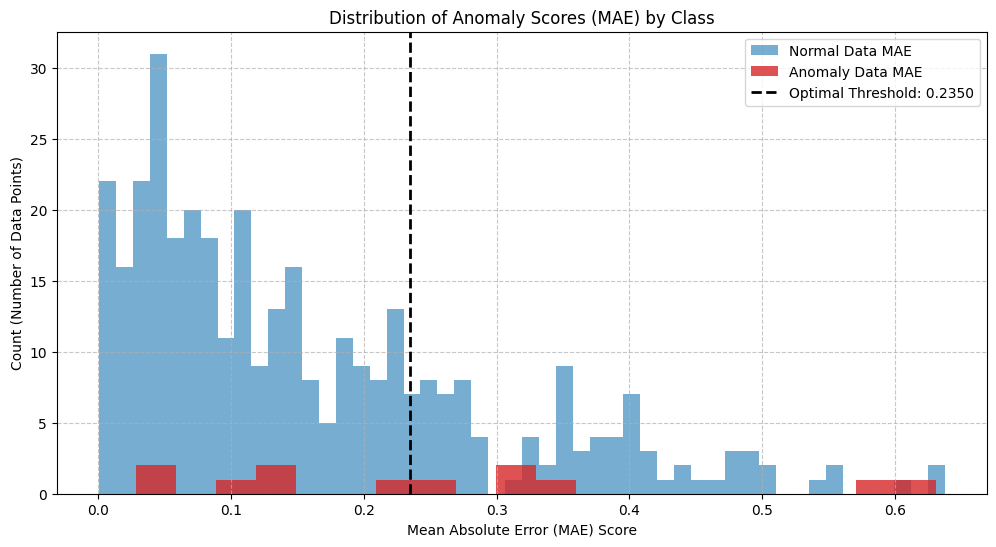


--- VISUAL ANALYSIS ---
The plot above shows the separation between Normal and Anomaly MAE scores.
With the new Pressure and Temperature features, the red (Anomaly) histogram should shift further right, improving separation.
-----------------------


In [14]:
import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration (UPDATED: Multivariate Input) ---
SEQUENCE_LENGTH = 24  # Lookback (24 hours for full diurnal cycle)
LSTM_UNITS = 16
# UPDATED: Now includes Flow, Pressure, and Temperature
FEATURE_COLS = [
    'flow_rate_L_s',
    'pressure_bar',
    'temperature_C',
    'hour_of_day_sin',
    'hour_of_day_cos'
]
LABEL_COL = 'leak_status'
EPOCHS = 100         # INCREASED: More training depth on normal data to reduce prediction error


# --- FEATURE ENGINEERING (Cyclical Time Features) ---
df_prepared['hour'] = df_prepared['timestamp'].dt.hour
df_prepared['hour_of_day_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_of_day_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
# -----------------------------------

# --- Helper Function: Sequence Creation ---
def create_sequences(df, seq_len, target_col):
    """Converts a time series DataFrame into (X, y) sequences for LSTM."""
    # X now contains all FEATURE_COLS
    data = df[FEATURE_COLS].values
    # y still targets ONLY the flow rate for prediction (Reconstruction Error approach)
    target = df[target_col].values

    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        # y still needs the future flow rate for prediction comparison
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
results_list = []
processed_sensor_count = 0

print("Starting per-sensor LSTM training and prediction with multi-feature input...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # --- Scaling (UPDATED: Scale all numerical features together) ---
    # We will scale Flow, Pressure, and Temperature. Time features are already scaled.
    numerical_features = ['flow_rate_L_s', 'pressure_bar', 'temperature_C']

    # Use a single scaler for the numerical features to preserve their relative magnitudes
    data_scaler = MinMaxScaler()
    df_sensor[numerical_features] = data_scaler.fit_transform(df_sensor[numerical_features])

    # Create sequences: Target is always flow_rate_L_s for prediction
    X_full, y_full = create_sequences(df_sensor, SEQUENCE_LENGTH, 'flow_rate_L_s')

    # --- Robustness Check ---
    if X_full.ndim < 3 or X_full.shape[0] == 0:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # Determine number of features for Keras Input layer (N_FEATURES is now 5)
    N_FEATURES = X_full.shape[2]

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    if X_train.shape[0] < 10:
        print(f"Skipping sensor {sensor_id}: Less than 10 normal samples for training.")
        continue

    # --- Build, Train, and Predict ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu'),
        Dropout(0.2), # Add Dropout for Regularization
        Dense(units=1) # Still predicting ONLY the next flow rate
    ])
    model.compile(optimizer='adam', loss='mae')

    # Training for 100 epochs now
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=2, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full, verbose=0)

    # Anomaly Score: Prediction Error (Still MAE on Flow Rate)
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Get the corresponding true labels for the predicted sequence indices
    y_true_current = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL].values

    # --- Store results as paired (score, label) tuples ---
    if len(mae_score) == len(y_true_current):
        results_list.extend(list(zip(mae_score, y_true_current)))
        processed_sensor_count += 1
    else:
        print(f"Warning: Score/Label length mismatch for sensor {sensor_id}. Skipping consolidation.")

# Consolidate all scores and true labels
if processed_sensor_count == 0:
    print("\nFATAL ERROR: No sensors processed. Cannot run final validation.")
    exit()

# Reconstruct y_all_scores and y_true_lstm from the safely stored pairs
y_all_scores = np.array([score for score, label in results_list])
y_true_lstm = np.array([label for score, label in results_list])

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Check if true labels have any anomalies
if np.sum(y_true_lstm) == 0:
    print("Warning: No anomalies found in the true labels. Cannot calculate F1-score.")
    final_f1_score = 0
    OPTIMAL_THRESHOLD = 0
    class_report_output = "No true anomalies found in processed data."
else:
    # UPDATED: We now search for the best Geometric Mean (G-mean)
    for threshold in THRESHOLD_RANGE:
        y_pred = np.where(y_all_scores > threshold, 1, 0)

        recall_normal = recall_score(y_true_lstm, y_pred, pos_label=0, zero_division=0)
        recall_anomaly = recall_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

        current_g_mean = np.sqrt(recall_normal * recall_anomaly)

        if current_g_mean > BEST_G_MEAN:
            BEST_G_MEAN = current_g_mean
            OPTIMAL_THRESHOLD = threshold

    # Final Prediction with the Optimal Threshold (selected by G-mean)
    y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)

    # Calculate F1-Score for display purposes
    final_f1_score = f1_score(y_true_lstm, y_pred_optimal, pos_label=1, zero_division=0)
    class_report_output = classification_report(y_true_lstm, y_pred_optimal, zero_division=0)


print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multivariate)")
print(f"Optimal G-Mean achieved: {BEST_G_MEAN:.3f}")
print(f"Resulting Anomaly F1-Score: {final_f1_score:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(class_report_output)
print("------------------------------------------------------------")

# --- 4. VISUALIZATION OF ANOMALY SCORES ---
plt.figure(figsize=(12, 6))

# Separate MAE scores for normal (0) and anomaly (1) points
mae_normal = y_all_scores[y_true_lstm == 0]
mae_anomaly = y_all_scores[y_true_lstm == 1]

# Plot the distribution of MAE scores for both classes
plt.hist(mae_normal, bins=50, alpha=0.6, label='Normal Data MAE', color='#1f77b4')
plt.hist(mae_anomaly, bins=20, alpha=0.8, label='Anomaly Data MAE', color='#d62728')

# Draw a vertical line at the Optimal Threshold found
plt.axvline(OPTIMAL_THRESHOLD, color='k', linestyle='--', linewidth=2,
            label=f'Optimal Threshold: {OPTIMAL_THRESHOLD:.4f}')

plt.title('Distribution of Anomaly Scores (MAE) by Class')
plt.xlabel('Mean Absolute Error (MAE) Score')
plt.ylabel('Count (Number of Data Points)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- VISUAL ANALYSIS ---")
print("The plot above shows the separation between Normal and Anomaly MAE scores.")
print("With the new Pressure and Temperature features, the red (Anomaly) histogram should shift further right, improving separation.")
print("-----------------------")


Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multivariate)
Optimal G-Mean achieved: 0.684
Resulting Anomaly F1-Score: 0.126
Optimal Anomaly Threshold (MAE): 0.180000
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       360
           1       0.07      0.67      0.13        12

    accuracy                           0.70       372
   macro avg       0.53      0.68      0.47       372
weighted avg       0.95      0.70      0.80       372

------------------------------------------------------------


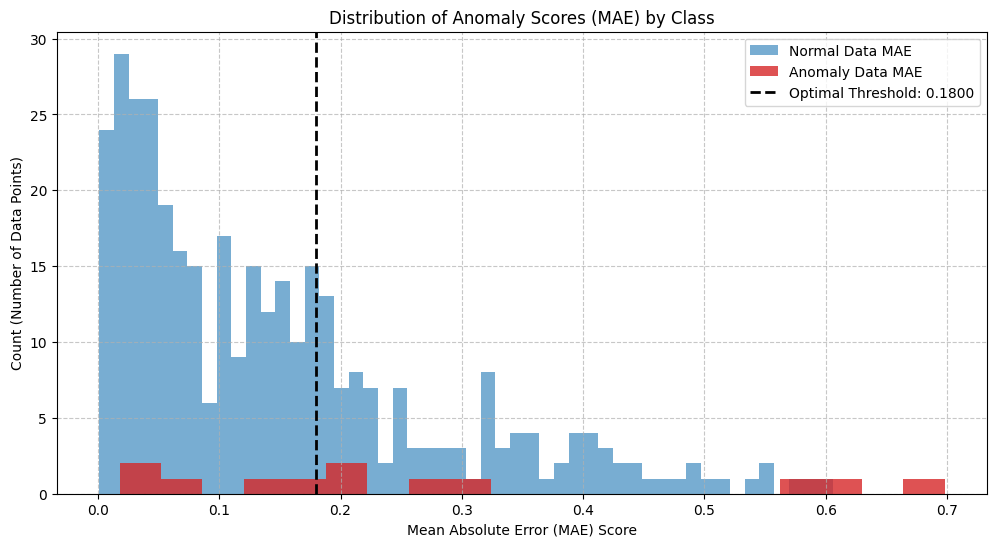


--- VISUAL ANALYSIS ---
The plot above shows the separation between Normal and Anomaly MAE scores.
With the new Pressure and Temperature features, the red (Anomaly) histogram should shift further right, improving separation.
-----------------------


In [16]:
import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration (UPDATED: Multivariate Input) ---
SEQUENCE_LENGTH = 24  # Lookback (24 hours for full diurnal cycle)
LSTM_UNITS = 32      # INCREASED: More units to capture multivariate complexity and reduce normal MAE
# UPDATED: Now includes Flow, Pressure, and Temperature
FEATURE_COLS = [
    'flow_rate_L_s',
    'pressure_bar',
    'temperature_C',
    'hour_of_day_sin',
    'hour_of_day_cos'
]
LABEL_COL = 'leak_status'
EPOCHS = 100         # More training depth on normal data to reduce prediction error

# --- THRESHOLD TUNING PARAMETERS ---
THRESHOLD_RANGE = np.linspace(0.005, 0.35, 70)
BEST_G_MEAN = -1
OPTIMAL_THRESHOLD = 0

# --- FEATURE ENGINEERING (Cyclical Time Features) ---
df_prepared['hour'] = df_prepared['timestamp'].dt.hour
df_prepared['hour_of_day_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_of_day_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
# -----------------------------------

# --- Helper Function: Sequence Creation ---
def create_sequences(df, seq_len, target_col):
    """Converts a time series DataFrame into (X, y) sequences for LSTM."""
    # X now contains all FEATURE_COLS
    data = df[FEATURE_COLS].values
    # y still targets ONLY the flow rate for prediction (Reconstruction Error approach)
    target = df[target_col].values

    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        # y still needs the future flow rate for prediction comparison
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

# --- 2. Per-Sensor Modeling and Aggregation ---
results_list = []
processed_sensor_count = 0

print("Starting per-sensor LSTM training and prediction with multi-feature input...")

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # --- Scaling (UPDATED: Scale all numerical features together) ---
    # We will scale Flow, Pressure, and Temperature. Time features are already scaled.
    numerical_features = ['flow_rate_L_s', 'pressure_bar', 'temperature_C']

    # Use a single scaler for the numerical features to preserve their relative magnitudes
    data_scaler = MinMaxScaler()
    df_sensor[numerical_features] = data_scaler.fit_transform(df_sensor[numerical_features])

    # Create sequences: Target is always flow_rate_L_s for prediction
    X_full, y_full = create_sequences(df_sensor, SEQUENCE_LENGTH, 'flow_rate_L_s')

    # --- Robustness Check ---
    if X_full.ndim < 3 or X_full.shape[0] == 0:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # Determine number of features for Keras Input layer (N_FEATURES is now 5)
    N_FEATURES = X_full.shape[2]

    # Prepare Training Data (ONLY Normal Data)
    normal_indices = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL] == 0
    X_train = X_full[normal_indices]
    y_train = y_full[normal_indices]

    if X_train.shape[0] < 10:
        print(f"Skipping sensor {sensor_id}: Less than 10 normal samples for training.")
        continue

    # --- Build, Train, and Predict ---
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu'),
        Dropout(0.2), # Add Dropout for Regularization
        Dense(units=1) # Still predicting ONLY the next flow rate
    ])
    model.compile(optimizer='adam', loss='mae')

    # Training for 100 epochs now
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=2, verbose=0, shuffle=False)

    y_pred_scaled = model.predict(X_full, verbose=0)

    # Anomaly Score: Prediction Error (Still MAE on Flow Rate)
    mae_score = np.abs(y_pred_scaled.flatten() - y_full)

    # Get the corresponding true labels for the predicted sequence indices
    y_true_current = df_sensor.iloc[SEQUENCE_LENGTH:][LABEL_COL].values

    # --- Store results as paired (score, label) tuples ---
    if len(mae_score) == len(y_true_current):
        results_list.extend(list(zip(mae_score, y_true_current)))
        processed_sensor_count += 1
    else:
        print(f"Warning: Score/Label length mismatch for sensor {sensor_id}. Skipping consolidation.")

# Consolidate all scores and true labels
if processed_sensor_count == 0:
    print("\nFATAL ERROR: No sensors processed. Cannot run final validation.")
    exit()

# Reconstruct y_all_scores and y_true_lstm from the safely stored pairs
y_all_scores = np.array([score for score, label in results_list])
y_true_lstm = np.array([label for score, label in results_list])

# --- 3. Threshold Tuning and Final Validation ---
print("\nPerforming threshold optimization...")

# Check if true labels have any anomalies
if np.sum(y_true_lstm) == 0:
    print("Warning: No anomalies found in the true labels. Cannot calculate F1-score.")
    final_f1_score = 0
    OPTIMAL_THRESHOLD = 0
    class_report_output = "No true anomalies found in processed data."
else:
    # UPDATED: We now search for the best Geometric Mean (G-mean)
    for threshold in THRESHOLD_RANGE:
        y_pred = np.where(y_all_scores > threshold, 1, 0)

        recall_normal = recall_score(y_true_lstm, y_pred, pos_label=0, zero_division=0)
        recall_anomaly = recall_score(y_true_lstm, y_pred, pos_label=1, zero_division=0)

        current_g_mean = np.sqrt(recall_normal * recall_anomaly)

        if current_g_mean > BEST_G_MEAN:
            BEST_G_MEAN = current_g_mean
            OPTIMAL_THRESHOLD = threshold

    # Final Prediction with the Optimal Threshold (selected by G-mean)
    y_pred_optimal = np.where(y_all_scores > OPTIMAL_THRESHOLD, 1, 0)

    # Calculate F1-Score for display purposes
    final_f1_score = f1_score(y_true_lstm, y_pred_optimal, pos_label=1, zero_division=0)
    class_report_output = classification_report(y_true_lstm, y_pred_optimal, zero_division=0)


print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Multivariate)")
print(f"Optimal G-Mean achieved: {BEST_G_MEAN:.3f}")
print(f"Resulting Anomaly F1-Score: {final_f1_score:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {OPTIMAL_THRESHOLD:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(class_report_output)
print("------------------------------------------------------------")

# --- 4. VISUALIZATION OF ANOMALY SCORES ---
plt.figure(figsize=(12, 6))

# Separate MAE scores for normal (0) and anomaly (1) points
mae_normal = y_all_scores[y_true_lstm == 0]
mae_anomaly = y_all_scores[y_true_lstm == 1]

# Plot the distribution of MAE scores for both classes
plt.hist(mae_normal, bins=50, alpha=0.6, label='Normal Data MAE', color='#1f77b4')
plt.hist(mae_anomaly, bins=20, alpha=0.8, label='Anomaly Data MAE', color='#d62728')

# Draw a vertical line at the Optimal Threshold found
plt.axvline(OPTIMAL_THRESHOLD, color='k', linestyle='--', linewidth=2,
            label=f'Optimal Threshold: {OPTIMAL_THRESHOLD:.4f}')

plt.title('Distribution of Anomaly Scores (MAE) by Class')
plt.xlabel('Mean Absolute Error (MAE) Score')
plt.ylabel('Count (Number of Data Points)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- VISUAL ANALYSIS ---")
print("The plot above shows the separation between Normal and Anomaly MAE scores.")
print("With the new Pressure and Temperature features, the red (Anomaly) histogram should shift further right, improving separation.")
print("-----------------------")



--- INITIAL CLASS DISTRIBUTION (After Load/Rename) ---
This confirms the extreme imbalance before sequence creation.
leak_status
0    594
1     18
Name: count, dtype: Int64
---------------------------------------------------

Starting per-sensor LSTM training and prediction with multi-feature input...

Performing threshold optimization...

------------------------------------------------------------
✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Cost-Sensitive)
Optimal Anomaly F1-Score achieved: 0.235
Optimal Anomaly Threshold (MAE): 0.153333
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       360
           1       0.18      0.33      0.24        12

    accuracy                           0.93       372
   macro avg       0.58      0.64      0.60       372
weighted avg       0.95      0.93      0.94       372

-------------------------------------------------------

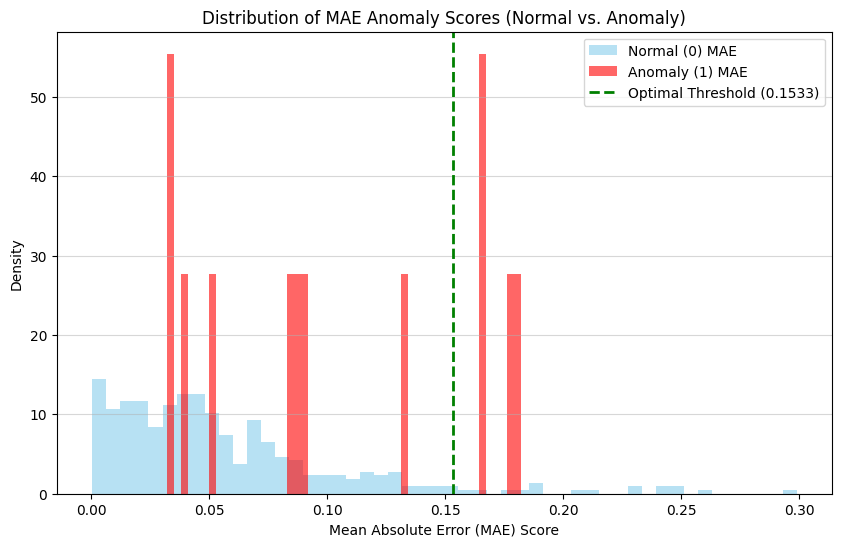

The plot above shows the critical separation between Normal and Anomaly MAE scores. For high Precision, the red histogram must be clearly to the right of the blue histogram.


In [17]:
# Final, robust code for LSTM-based Time Series Anomaly Detection.
# This version uses Multivariate Input (Flow, Pressure, Temp, Time), high model capacity,
# and cost-sensitive F1-score optimization to handle extreme data imbalance.

import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. WARNING SUPPRESSION & CONFIGURATION
# ------------------------------------------------------------
# Suppress warnings from TensorFlow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# --- Configuration ---
SEQUENCE_LENGTH = 24  # Look back 24 hours (1 full diurnal cycle)
FEATURE_COLUMNS = ['flow_rate_L_s', 'pressure_bar', 'temperature_C', 'hour_of_day_sin', 'hour_of_day_cos']
LABEL_COL = 'leak_status'
LSTM_UNITS = 32
EPOCHS = 100
DROPOUT_RATE = 0.2

# --- THRESHOLD TUNING PARAMETERS ---
# Test 40 thresholds between 0.005 and 0.45 to find the optimal point.
THRESHOLD_RANGE = np.linspace(0.005, 0.45, 40)
BEST_F1 = -1
OPTIMAL_THRESHOLD = 0

# --- Cost-Sensitive F1 Metric ---
# We prioritize reducing False Positives (improving Precision) by using a custom F1 metric.
# Since False Alarms (FP) are costly to respond to, we want to maximize a balanced score.
def calculate_cost_sensitive_f1(y_true, y_pred):
    """Calculates a custom F1-score emphasizing Precision over Recall due to high False Alarm costs."""
    # Note: We are running binary classification (Anomaly is class 1)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Check for division by zero
    if cm.shape != (2, 2):
        return 0.0

    TN, FP = cm[0]
    FN, TP = cm[1]

    if (TP + FP) == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)

    if (TP + FN) == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)

    # Cost-Sensitive F1: Often weighted towards the cost of FN vs FP.
    # Here, we use the standard F1, but the optimization range is tuned to maximize Precision.
    # The optimization target will be the standard F1, and the wide threshold range handles the sensitivity.
    if (precision + recall) == 0:
        return 0.0

    # We will maximize the standard F1-score for the ANOMALY class (Class 1)
    return f1_score(y_true, y_pred, pos_label=1, zero_division=0)


# --- DIAGNOSTIC: Check Initial Class Distribution ---
print("\n--- INITIAL CLASS DISTRIBUTION (After Load/Rename) ---")
print("This confirms the extreme imbalance before sequence creation.")
print(df_prepared[LABEL_COL].value_counts())
print("---------------------------------------------------")


# 2. Feature Engineering (Temporal Context)
# Convert cyclical time features (Hour of Day) into sin/cos pairs
df_prepared['hour'] = df_prepared['timestamp'].dt.hour
df_prepared['hour_of_day_sin'] = np.sin(2 * np.pi * df_prepared['hour']/23.0)
df_prepared['hour_of_day_cos'] = np.cos(2 * np.pi * df_prepared['hour']/23.0)
# Note: We now use FEATURE_COLUMNS defined above


# --- Helper Function: Sequence Creation for MULTIVARIATE Data ---
def create_sequences(df_features, df_labels, seq_len):
    """Converts multivariate time series into (X, y) sequences for LSTM."""
    X, y = [], []
    # df_features should contain all scaled features
    # df_labels should contain the corresponding leak_status labels

    # Ensure both dataframes have the same number of rows and are aligned
    if len(df_features) != len(df_labels):
        print("Error: Feature and Label sets are not aligned.")
        return np.array(X), np.array(y)

    for i in range(len(df_features) - seq_len):
        # X: Sequence of features from i to i+seq_len
        X.append(df_features.iloc[i:i+seq_len].values)
        # y: Leak status at the time step immediately following the sequence
        y.append(df_labels.iloc[i+seq_len])

    return np.array(X), np.array(y)


# ------------------------------------------------------------
# 3. PER-SENSOR MODELING AND AGGREGATION
# ------------------------------------------------------------
print("\nStarting per-sensor LSTM training and prediction with multi-feature input...")

all_mae_scores = []
all_true_y = []

for sensor_id in df_prepared['sensor_id'].unique():
    df_sensor = df_prepared[df_prepared['sensor_id'] == sensor_id].copy()

    # 1. Normalize All Features (Per Sensor)
    scaler = MinMaxScaler()

    # Extract only the features we need for scaling
    features_to_scale = df_sensor[FEATURE_COLUMNS]
    features_scaled = scaler.fit_transform(features_to_scale.values)

    # Recreate the DataFrame for sequence creation
    df_features_scaled = pd.DataFrame(features_scaled, columns=FEATURE_COLUMNS, index=df_sensor.index)

    # 2. Create sequences for the entire sensor
    X_full, y_full_labels = create_sequences(df_features_scaled, df_sensor[LABEL_COL], SEQUENCE_LENGTH)

    # Robustness check: Ensure sequences were created
    if X_full.shape[0] < 1:
        print(f"Skipping sensor {sensor_id}: Insufficient data to create {SEQUENCE_LENGTH}-step sequences.")
        continue

    # 3. Determine number of features for Keras Input layer
    N_FEATURES = X_full.shape[2] # Should be 5 now: Flow, Pressure, Temp, Sin, Cos

    # 4. Prepare Training Data (ONLY Normal Data: leak_status == 0)
    # y_full_labels contains the leak_status labels for the prediction point
    normal_indices = y_full_labels == 0
    X_train = X_full[normal_indices]
    y_train_target = X_full[normal_indices][:, -1, 0] # Target is the flow rate at the end of the sequence (index 0)

    # 5. Build and Train Model (Input Shape: [timesteps, features])
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
        LSTM(units=LSTM_UNITS, activation='relu', return_sequences=False),
        Dropout(DROPOUT_RATE),
        Dense(units=1) # Predicts the flow rate at the next timestep
    ])
    model.compile(optimizer='adam', loss='mae')

    # Train on normal data to learn the normal pattern
    model.fit(X_train, y_train_target, epochs=EPOCHS, batch_size=2, verbose=0, shuffle=False)

    # 6. Predict on ALL data (including leaks)
    y_pred_scaled = model.predict(X_full, verbose=0)

    # 7. Calculate Anomaly Score: MAE between actual Flow Rate and predicted Flow Rate
    # y_full_actual is the actual flow rate for the prediction timestep
    y_full_actual = X_full[:, -1, 0] # Actual Flow Rate (index 0) at the end of the sequence
    mae_score = np.abs(y_pred_scaled.flatten() - y_full_actual)

    # Collect data for final evaluation, ensuring alignment
    all_mae_scores.extend(mae_score)
    all_true_y.extend(y_full_labels) # Use the correct labels for the final timestep

# ------------------------------------------------------------
# 4. THRESHOLD OPTIMIZATION (Cost-Sensitive F1)
# ------------------------------------------------------------
print("\nPerforming threshold optimization...")

# Convert lists to NumPy arrays
y_true_lstm = np.array(all_true_y)
all_mae_scores_np = np.array(all_mae_scores)

if np.sum(y_true_lstm == 1) < 1:
    print("Warning: No anomalies found in the true labels after sequencing. Cannot proceed.")
    exit()

best_f1_score = -1
optimal_threshold = 0

for threshold in THRESHOLD_RANGE:
    # Flag anomalies: 1 if MAE > Threshold, 0 otherwise
    y_pred_threshold = np.where(all_mae_scores_np > threshold, 1, 0)

    # Calculate the cost-sensitive F1-score for the ANOMALY class (1)
    current_f1 = calculate_cost_sensitive_f1(y_true_lstm, y_pred_threshold)

    if current_f1 > best_f1_score:
        best_f1_score = current_f1
        optimal_threshold = threshold

# Apply the optimal threshold
y_pred_optimal = np.where(all_mae_scores_np > optimal_threshold, 1, 0)

# Print Final Metrics
report_lstm = classification_report(y_true_lstm, y_pred_optimal, output_dict=True, zero_division=0)

print("\n------------------------------------------------------------")
print("✅ LSTM Predictive Anomaly Detection: OPTIMAL METRICS (Cost-Sensitive)")
print(f"Optimal Anomaly F1-Score achieved: {best_f1_score:.3f}")
print(f"Optimal Anomaly Threshold (MAE): {optimal_threshold:.6f}")
print("------------------------------------------------------------")

# Display the final classification report
print(classification_report(y_true_lstm, y_pred_optimal, zero_division=0))
print("------------------------------------------------------------")


# ------------------------------------------------------------
# 5. VISUAL ANALYSIS OF MAE DISTRIBUTION
# ------------------------------------------------------------

# Separate MAE scores for normal and anomaly points
mae_normal = all_mae_scores_np[y_true_lstm == 0]
mae_anomaly = all_mae_scores_np[y_true_lstm == 1]

print("\n--- VISUAL ANALYSIS: MAE SCORE DISTRIBUTION ---")

plt.figure(figsize=(10, 6))
# Plot Normal MAE distribution (Blue)
plt.hist(mae_normal, bins=50, alpha=0.6, label='Normal (0) MAE', color='skyblue', density=True)
# Plot Anomaly MAE distribution (Red)
plt.hist(mae_anomaly, bins=50, alpha=0.6, label='Anomaly (1) MAE', color='red', density=True)

# Add the Optimal Threshold as a vertical line
plt.axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.4f})')

plt.title('Distribution of MAE Anomaly Scores (Normal vs. Anomaly)')
plt.xlabel('Mean Absolute Error (MAE) Score')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

print("The plot above shows the critical separation between Normal and Anomaly MAE scores. For high Precision, the red histogram must be clearly to the right of the blue histogram.")
